In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

sns.set()
sns.set_palette("husl",2)
warnings.filterwarnings("ignore")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
       
# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv') #importing the data

# **I - Getting to know the data**

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
701,702,1,1,"Silverthorne, Mr. Spencer Victor",male,35.0,0,0,PC 17475,26.2875,E24,S
640,641,0,3,"Jensen, Mr. Hans Peder",male,20.0,0,0,350050,7.8542,NaN,S
570,571,1,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.5000,NaN,S
209,210,1,1,"Blank, Mr. Henry",male,40.0,0,0,112277,31.0000,A31,C
424,425,0,3,"Rosblom, Mr. Viktor Richard",male,18.0,1,1,370129,20.2125,NaN,S
722,723,0,2,"Gillespie, Mr. William Henry",male,34.0,0,0,12233,13.0000,NaN,S
117,118,0,2,"Turpin, Mr. William John Robert",male,29.0,1,0,11668,21.0000,NaN,S
206,207,0,3,"Backstrom, Mr. Karl Alfred",male,32.0,1,0,3101278,15.8500,NaN,S
243,244,0,3,"Maenpaa, Mr. Matti Alexanteri",male,22.0,0,0,STON/O 2. 3101275,7.1250,NaN,S
110,111,0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.0000,C110,S


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# **II - Cleaning the data :**
 - The Cabin column has 687 NaN values out of 891 lines : let's drop the whole column, 
 - Lets drop also the PassengerId and Ticket columns as values seem to be random,
 - The NaN in the Age column will be filled with the median. In the Embarked column, NaN will be replaced by the most frequent value.

In [7]:
data = train.copy() #We will work on a copy of our data
data.drop(['PassengerId','Cabin','Ticket'],axis=1,inplace=True)
data['Age'].fillna(data['Age'].median(),inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0],inplace=True)

In [8]:
data.isna().sum() #one more check

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

# **III - Basic feature engineering**
1. The SibSp and Parch features reports respectively the number of spouse and sibling and the number of parents or childs accompanying each passenger. We should create a family feature summing these 2 informations
2. The names may not help us predict survival of an individual but maybe the title will : lets replace the name feature by the title

In [9]:
data['Family'] = data['SibSp'] + data['Parch'] #creating the family feature
data[['Family','SibSp','Parch']].sample(5) #quick check

,Family,SibSp,Parch
739,0,0,0
353,1,1,0
540,2,0,2
217,1,1,0
551,0,0,0


In [10]:
#Engineering the Title feature by first parsing the names to extract titles
data['Title'] = data['Name'].apply(lambda x: x.partition(',')[2].partition('.')[0])
data[['Name','Title']].sample(5)#quick check

,Name,Title
796,"Leader, Dr. Alice (Farnham)",Dr
115,"Pekoniemi, Mr. Edvard",Mr
767,"Mangan, Miss. Mary",Miss
317,"Moraweck, Dr. Ernest",Dr
488,"Somerton, Mr. Francis William",Mr


In [11]:
data['Title'].value_counts()#desplaying the number of occurences by values

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Col               2
 Mlle              2
 Major             2
 Mme               1
 Sir               1
 Don               1
 Jonkheer          1
 the Countess      1
 Lady              1
 Ms                1
 Capt              1
Name: Title, dtype: int64

We can see that some titles have too few occurences in the dataset to be meaningful, lets group all titles with less than 10 occurences in the same category. The number 10 is arbitratry but look like a good fit for our data. We can always change it later anyway.



In [12]:
rare_titles = (data['Title'].value_counts() < 10) #this line returns a Series with the titles as index and a column stating is the title is rare or not
rare_titles

 Mr              False
 Miss            False
 Mrs             False
 Master          False
 Dr               True
 Rev              True
 Col              True
 Mlle             True
 Major            True
 Mme              True
 Sir              True
 Don              True
 Jonkheer         True
 the Countess     True
 Lady             True
 Ms               True
 Capt             True
Name: Title, dtype: bool

In [13]:
#Replacing rare titles with 'Rare'
data['Title'] = data['Title'].apply(lambda x: 'Rare' if rare_titles[x] else x)
data['Title'].value_counts()

 Mr        517
 Miss      182
 Mrs       125
 Master     40
Rare        27
Name: Title, dtype: int64

In [14]:
#now let's drop the column Name as we do not need it anymore
data.drop('Name',axis=1,inplace=True)

That's it for now regarding feature engineering.

In [15]:
data.sample(5)# Quick look at our data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Title
629,0,3,male,28.0,0,0,7.7333,Q,0,Mr
548,0,3,male,33.0,1,1,20.5250,S,2,Mr
62,0,1,male,45.0,1,0,83.4750,S,1,Mr
752,0,3,male,33.0,0,0,9.5000,S,0,Mr
692,1,3,male,28.0,0,0,56.4958,S,0,Mr


# **IV - Data exploration**

We are trying to know each feature a bit better 

Text(0.5, 1.0, 'Survival rate per class')

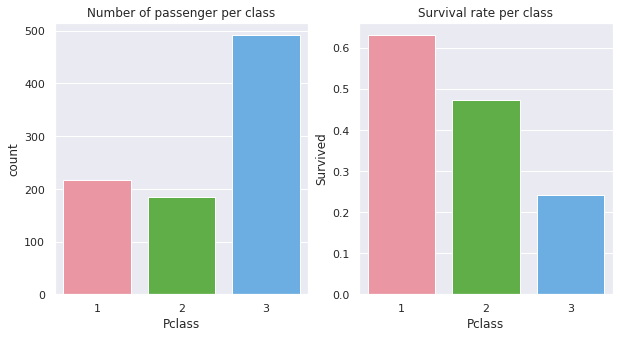

In [16]:
# Pclass
fig, axis = plt.subplots(1,2,figsize=(10,5))

sns.countplot(x='Pclass',data=data,ax = axis[0])
axis[0].set_title('Number of passenger per class')

sns.barplot(x='Pclass',y='Survived',data=data,ax = axis[1],ci=None)
axis[1].set_title('Survival rate per class')

Most of the passengers were in 3rd class. Unsurprisingly a higher class means a higher chance of survival, Pclass is likely to be important to predict the survival.

Text(0.5, 1.0, 'Survival rate per gender')

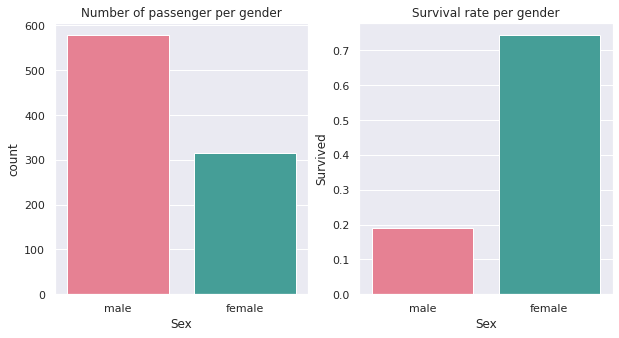

In [17]:
#Gender feature
fig2, axis2 = plt.subplots(1,2,figsize=(10,5))

sns.countplot(x='Sex',data=data,ax = axis2[0])
axis2[0].set_title('Number of passenger per gender')

sns.barplot(x='Sex',y='Survived',data=data,ax = axis2[1],ci=None)
axis2[1].set_title('Survival rate per gender')

We can see that most of the women survived and very few male did, therefore the Sex feature is likely to be a strong indicator on rather an individual survived or not.

Text(0.5, 1.0, 'Shape of the Age distribution')

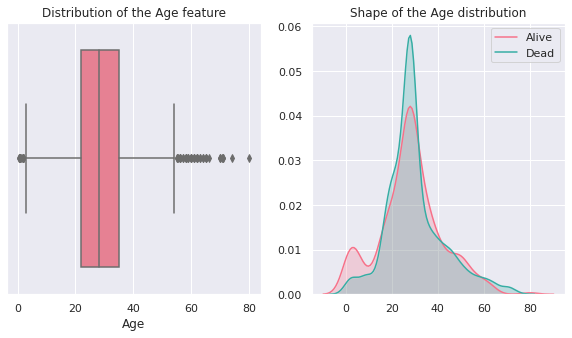

In [18]:
#Age feature
fig3, axis3 = plt.subplots(1,2,figsize=(10,5))

sns.boxplot(x='Age',data=data,ax = axis3[0])
axis3[0].set_title('Distribution of the Age feature')

sns.kdeplot(data[data.Survived==1].Age,shade=True,label='Alive',ax=axis3[1])
sns.kdeplot(data[data.Survived==0].Age,shade=True,label='Dead',ax=axis3[1])
axis3[1].set_title('Shape of the Age distribution')

The Age values seem are included in the [0;80] interval, therefore there is no aberrant value
The shape of the data does not show a clear difference between the dead and the alive.

Text(0.5, 1.0, 'Survival rate per family size')

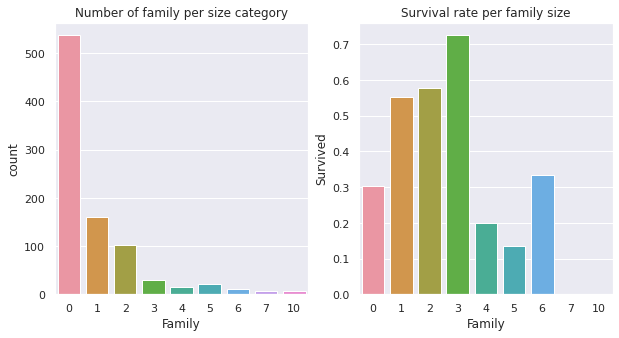

In [19]:
#Family feature
fig4, axis4 = plt.subplots(1,2,figsize=(10,5))

sns.countplot(x='Family',data=data,ax = axis4[0])
axis4[0].set_title('Number of family per size category')

sns.barplot(x='Family',y='Survived',data=data,ax = axis4[1],ci=None)
axis4[1].set_title('Survival rate per family size')

We can see that most of the passenger traveled alone and that having family seem to have a positive impact on the chance of survival up to 3 members. 
At first we would be tempted to split the data in 3 categories : alone, family size between 1 and 3 and family size of more than 3. 
However we dont have a significant number of sample for family size of more than 2. Therefore it is safer to only split in 2 categories : alone or not.

In [20]:
#creation of the feature Alone
data['Alone'] = data['Family'].apply(lambda x : 0 if x > 0 else 1)

Text(0.5, 1.0, 'Survival rate per boarding location')

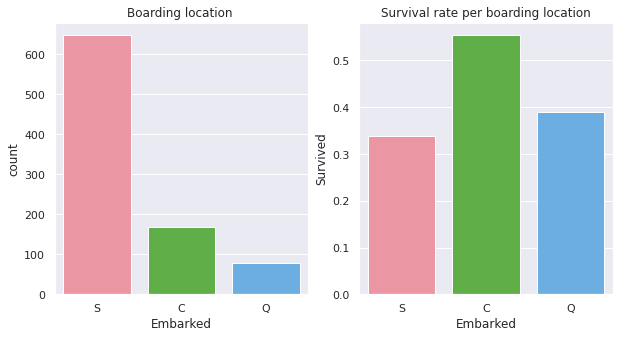

In [21]:
#examination of the Embarked feature
fig5, axis5 = plt.subplots(1,2,figsize=(10,5))

sns.countplot(x='Embarked',data=data,ax = axis5[0])
axis5[0].set_title('Boarding location ')

sns.barplot(x='Embarked',y='Survived',data=data,ax = axis5[1],ci=None)
axis5[1].set_title('Survival rate per boarding location')

Most passenger embarked in Southampton (S) however, passengers who boarded in Cherbourg (C) or in Queenstown (Q) had a better chance of survival. 
Let's examine the Pclass distribution for each boarding location,if most of the higher classes embarked in Cherbourg it would explain the differences.

Text(0.5, 1.0, 'Pclass distribution per boarding location')

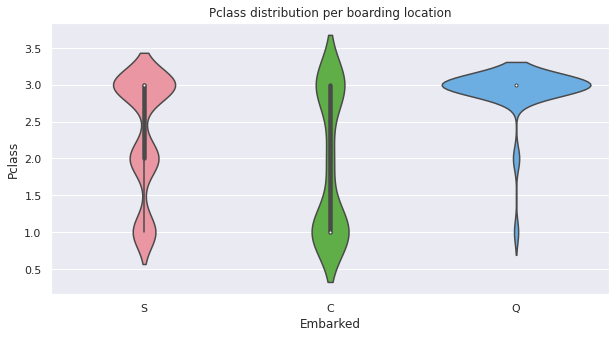

In [22]:
fig5b, axis5b = plt.subplots(1,1,figsize=(10,5))
sns.violinplot(x = 'Embarked', y = 'Pclass', data=data,ax=axis5b)
axis5b.set_title('Pclass distribution per boarding location')

The graphic above does not show any clear correlation between boarding location and Pclass.

Text(0.5, 1.0, 'Shape of the Fare distribution')

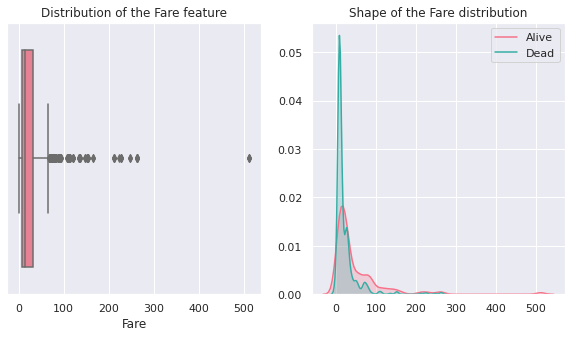

In [23]:
#Fare feature
fig6, axis6 = plt.subplots(1,2,figsize=(10,5))

sns.boxplot(x='Fare',data=data,ax = axis6[0])
axis6[0].set_title('Distribution of the Fare feature')

sns.kdeplot(data[data['Survived']==1]['Fare'],shade=True,label='Alive',ax=axis6[1])
sns.kdeplot(data[data['Survived']==0]['Fare'],shade=True,label='Dead',ax=axis6[1])
axis6[1].set_title('Shape of the Fare distribution')

The first thing we notice is that we have an outlier in the data. There is no obvious correction and the value is 'only' twice the second highest. Let's verify that the Fare and Pclass are consistent. 

Text(0.5, 1.0, 'Fare by Pclass')

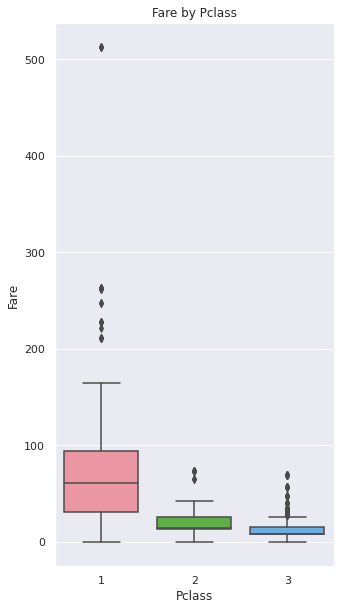

In [24]:
fig6b, axis6b = plt.subplots(1,1,figsize=(5,10))
sns.boxplot(x='Pclass',y='Fare',data=data,ax=axis6b)
axis6b.set_title('Fare by Pclass')

The higher the Fare, the higher the Pclass. Our outlier fare is in the first class so we should keep it in the data. 

Text(0.5, 1.0, 'Survival rate per title category')

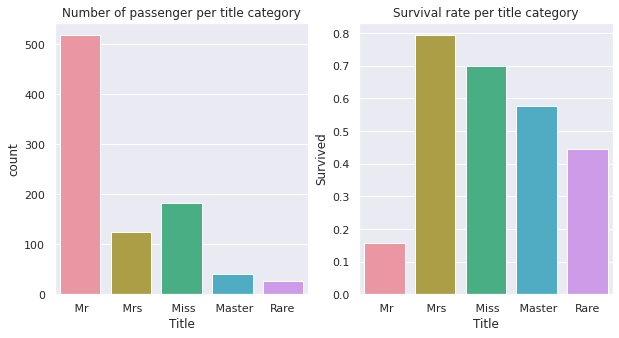

In [25]:
#examination of the Title feature
fig7, axis7 = plt.subplots(1,2,figsize=(10,5))

sns.countplot(x='Title',data=data,ax = axis7[0])
axis7[0].set_title('Number of passenger per title category')

sns.barplot(x='Title',y='Survived',data=data,ax = axis7[1],ci=None)
axis7[1].set_title('Survival rate per title category')

We already knew that most of the passenger were male and that female had a better chance of survival therefore it is consistant that female titles have a better chance of surivival. 
Master and the others Rare titles have a better chance of survival. This feature is therefore usefull to predict the survival.

# **V - Model selection**

First, let's create a function with all the data preprocessing steps (cleaning, feature engineering and encoding). It will help us greatly if we want to do thoses steps multiple times, when predicting the test dataset for example.

In [26]:

def data_cleaning_and_feature_engineering(data):
    '''Preprocessing steps for the titanic dataset'''
    
    #filling NaN 
    data['Age'].fillna(data['Age'].median(),inplace=True)
    data['Embarked'].fillna(data['Embarked'].mode()[0],inplace=True)
    
    #feature engineering
    data['Title'] = data['Name'].apply(lambda x: x.partition(',')[2].partition('.')[0])
    rare_titles = (data['Title'].value_counts() < 10) #this line returns a Series with the titles as index and a column stating is the title is rare or not
    data['Title'] = data['Title'].apply(lambda x: 'Rare' if rare_titles[x] else x)
    
    data['Family'] = data['SibSp'] + data['Parch'] #creating the family feature
    data['Alone'] = data['Family'].apply(lambda x : 0 if x > 0 else 1)


    #encode categoricals
    label = LabelEncoder()
    data['Title'] = label.fit_transform(data['Title'])
    data['Sex'] = label.fit_transform(data['Sex'])
    data['Embarked'] = label.fit_transform(data['Embarked'])
  
    #drop unused columns
    data.drop(['PassengerId','Cabin','Ticket','Name'],axis=1,inplace=True)



In [27]:
data2 = train.copy() #working on a fresh copy of the dataset
data_cleaning_and_feature_engineering(data2)#applying all preprocessing steps

X = data2.drop('Survived',axis=1,inplace=False)
y = data2['Survived']

Next we will try out a few models on select the one that gives the better score.

In [28]:
#The selection of models is arbitrary
models =[] 
models.append(('XGBC',XGBClassifier()))
models.append(('RDF',RandomForestClassifier()))
models.append(('DT',DecisionTreeClassifier()))
models.append(('KN',KNeighborsClassifier()))
models.append(('SVM',SVC(gamma='auto')))

Each model will be evaluated using Kfold in order to have a meaningful evaluation.
The accuracy score is chosen as metric in this example because it's easy to understand.

In [29]:
names = []
results = []
for name,model in models:
    kfold = StratifiedKFold(n_splits=5)
    cv_res = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    results.append(cv_res)
    names.append(name)
    print(name, cv_res.mean(), cv_res.std())

XGBC 0.8204193082669009 0.03538615614244243
RDF 0.8047266336074321 0.0325575911705217
DT 0.7777854497520558 0.029364414605258054
KN 0.6981294331805913 0.03302046859344747
SVM 0.7071558596447178 0.04414545287545926


The most accurate model is the XGBC classifier with an accuracy score of 0.8204. Let's try to improve the score by tuning some parameter of the model using grid search. 

# **VI - Parameters tunning**

XGBC classifier has many parameters but for this project we will focus on 7 parameters :

1. learning_rate [default=0.1] : It is used to reduce the effect of each additionnal tree in order to try and avoid overfitting
2. n_estimators [default=100] : The number of trees. 
1. min_child_weight [default=1] : Defines the minimum sum of weights of all observations required in a child, it is used to avoid over-fitting by using higher values than default.
2. max_depth [default=6] : Controls the max depth of a tree. It is also used to control over-fitting. The deeper the tree, the more specific to a particular sample it is.
3. gamma [default=0] : A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split. 
4. subsample [default=1] : Denotes the fraction of observations to be randomly samples for each tree. The value should be tuned, smaller values reduce over-fitting but too small values lead to under-fitting.
5. colsample_bytree [default=1] : Denotes the fraction of columns to be randomly samples for each tree. It should be tuned the same way as subsample.


We will use the function GridSearchCV to help us find the right values. As this 'brut force' method is very computationally expensive, we will try only a few value of each parameter for this example.

In [30]:
param_test = {
"learning_rate": [0.1, 0.01],
'n_estimators' : [100, 500,1000],
'min_child_weight':[1, 3, 5, 7],
'max_depth': [2, 4, 7, 10],
'gamma': [0, 1,5],
'subsample':[0.3, 0.8, 1.0],
'colsample_bytree':[0.3, 0.8, 1.0]
}
search = GridSearchCV(estimator = XGBClassifier(), 
param_grid = param_test, scoring='accuracy',n_jobs=-1,iid=False, cv=5)

search.fit(X,y)
print(search.best_params_, search.best_score_)

{'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 1000, 'subsample': 0.8} 0.852984746720231


After (a long) computation, the accuracy score is 0.8529 with the parameters :
colsample_bytree: 0.8
 gamma: 1
learning_rate : 0.1
max_depth : 7
min_child_weight : 5
n_estimators : 1000
subsample : 0.8 

This is already an improvement ! Let's do this test one more time with range centered on this values.

In [31]:
param_test2 = {
"learning_rate": [0.1,0.06],
'n_estimators' : [900, 1000, 1100],
'min_child_weight':[4,5,6],
'max_depth': [6,7,8],
'gamma': [0.9,1],
'subsample':[0.7,0.8,0.9],
'colsample_bytree':[0.7,0.8,0.9]
}
search = GridSearchCV(estimator = XGBClassifier(), 
param_grid = param_test2, scoring='accuracy',n_jobs=-1,iid=False, cv=5)

search.fit(X,y)
print(search.best_params_, search.best_score_)

{'colsample_bytree': 0.9, 'gamma': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 1000, 'subsample': 0.9} 0.8574665746029753


The parameters, learning_rate, n_estimators, min_child_weight, max_depth, subsample  already reached the optimal value therefore we will leave them as they are.
Only gamma remain to be tuned.

In [32]:
param_test3 = {
"learning_rate": [0.1],
'n_estimators' : [1000],
'min_child_weight':[5],
'max_depth': [7],
'gamma': [0,4,0.7,0.8, 0.9],
'subsample':[0.9],
'colsample_bytree':[0.9]
}
search = GridSearchCV(estimator = XGBClassifier(), 
param_grid = param_test3, scoring='accuracy',n_jobs=-1,iid=False, cv=5)

search.fit(X,y)
print(search.best_params_, search.best_score_)

{'colsample_bytree': 0.9, 'gamma': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 1000, 'subsample': 0.9} 0.8574665746029753


The final accuracy score is 0.8574, with all the default values the accuracy was 0.8204. We can conclude that it is possible to improve the accuracy score by tuning the parameters but only slightly.

In order to improve the level of prediction on new data (test set on Kaggle), we could :
- Use a different type of score for tunning the algorithm. Accuracy is easier to understand but may not be the better choice;
- Do more advanced feature engineering;
- Tune all the parameters of the model as only some where done here;
- Make sure that the model is not overfitting;
- Create ensemble of models or use stacking.
